In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
# use NMA plot style
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")
my_layout = widgets.Layout()

In [3]:
def plot_volt_trace(pars, v, sp):
    """
    Plot trajetory of membrane potential for a single neuron

    Expects:
    pars   : parameter dictionary
    v      : volt trajetory
    sp     : spike train

    Returns:
    figure of the membrane potential trajetory for a single neuron
    """

    V_th = pars['V_th']
    dt, range_t = pars['dt'], pars['range_t']
    if sp.size:
        sp_num = (sp / dt).astype(int) - 1
        v[sp_num] += 20  # draw nicer spikes

    plt.plot(pars['range_t'], v, 'b')
    plt.axhline(V_th, 0, 1, color='k', ls='--')
    plt.xlabel('Time (ms)')
    plt.ylabel('V (mV)')
    plt.legend(['Membrane\npotential', r'Threshold V$_{\mathrm{th}}$'],
               loc=[1.05, 0.75])
    plt.ylim([-80, -40])
    plt.show()


def plot_GWN(pars, I_GWN):
    """
    Args:
      pars  : parameter dictionary
      I_GWN : Gaussian white noise input

    Returns:
      figure of the gaussian white noise input
    """

    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.plot(pars['range_t'][::3], I_GWN[::3], 'b')
    plt.xlabel('Time (ms)')
    plt.ylabel(r'$I_{GWN}$ (pA)')
    plt.subplot(122)
    plot_volt_trace(pars, v, sp)
    plt.tight_layout()
    plt.show()


def my_hists(isi1, isi2, cv1, cv2, sigma1, sigma2):
    """
    Args:
      isi1 : vector with inter-spike intervals
      isi2 : vector with inter-spike intervals
      cv1  : coefficient of variation for isi1
      cv2  : coefficient of variation for isi2

    Returns:
      figure with two histograms, isi1, isi2

    """
    plt.figure(figsize=(11, 4))
    my_bins = np.linspace(10, 30, 20)
    plt.subplot(121)
    plt.hist(isi1, bins=my_bins, color='b', alpha=0.5)
    plt.xlabel('ISI (ms)')
    plt.ylabel('count')
    plt.title(r'$\sigma_{GWN}=$%.1f, CV$_{\mathrm{isi}}$=%.3f' % (sigma1, cv1))

    plt.subplot(122)
    plt.hist(isi2, bins=my_bins, color='b', alpha=0.5)
    plt.xlabel('ISI (ms)')
    plt.ylabel('count')
    plt.title(r'$\sigma_{GWN}=$%.1f, CV$_{\mathrm{isi}}$=%.3f' % (sigma2, cv2))
    plt.tight_layout()
    plt.show()

In [5]:
def default_pars(**kwargs):
    pars = {}

    # typical neuron parameters#
    pars['V_th'] = -55.     # spike threshold [mV]
    pars['V_reset'] = -75.  # reset potential [mV]
    pars['tau_m'] = 10.     # membrane time constant [ms]
    pars['g_L'] = 10.       # leak conductance [nS]
    pars['V_init'] = -75.   # initial potential [mV]
    pars['E_L'] = -75.      # leak reversal potential [mV]
    pars['tref'] = 2.       # refractory time (ms)

    # simulation parameters #
    pars['T'] = 400.  # Total duration of simulation [ms]
    pars['dt'] = .1   # Simulation time step [ms]

    # external parameters if any #
    for k in kwargs:
        pars[k] = kwargs[k]

    pars['range_t'] = np.arange(0, pars['T'], pars['dt'])  # Vector of discretized time points [ms]

    return pars


pars = default_pars()
print(pars)

{'V_th': -55.0, 'V_reset': -75.0, 'tau_m': 10.0, 'g_L': 10.0, 'V_init': -75.0, 'E_L': -75.0, 'tref': 2.0, 'T': 400.0, 'dt': 0.1, 'range_t': array([0.000e+00, 1.000e-01, 2.000e-01, ..., 3.997e+02, 3.998e+02,
       3.999e+02])}


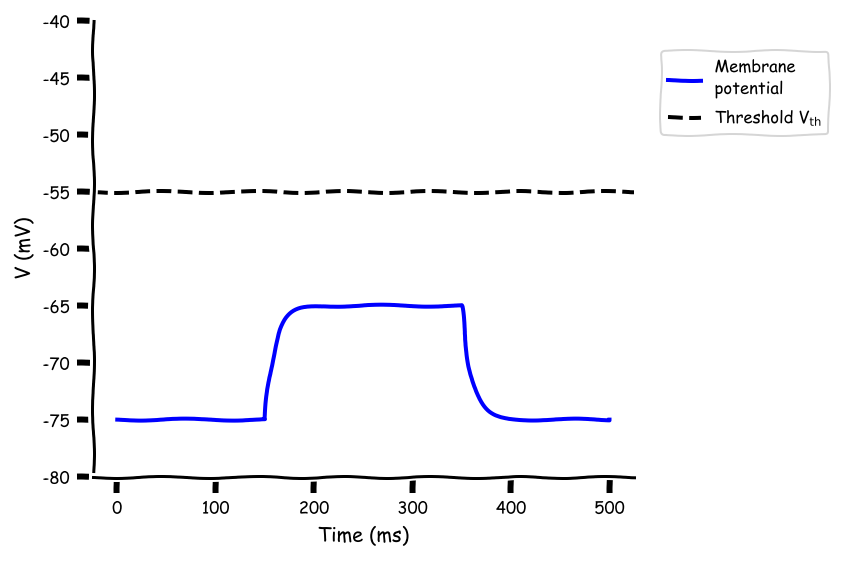

In [6]:
def run_LIF(pars, Iinj, stop=False):
    """
    Simulate the LIF dynamics with external input current

    Args:
      pars       : parameter dictionary
      Iinj       : input current [pA]. The injected current here can be a value
                   or an array
      stop       : boolean. If True, use a current pulse

    Returns:
      rec_v      : membrane potential
      rec_sp     : spike times
    """

    # Set parameters
    V_th, V_reset = pars['V_th'], pars['V_reset']
    tau_m, g_L = pars['tau_m'], pars['g_L']
    V_init, E_L = pars['V_init'], pars['E_L']
    dt, range_t = pars['dt'], pars['range_t']
    Lt = range_t.size
    tref = pars['tref']

    # Initialize voltage
    v = np.zeros(Lt)
    v[0] = V_init

    # Set current time course
    Iinj = Iinj * np.ones(Lt)

    # If current pulse, set beginning and end to 0
    if stop:
        Iinj[:int(len(Iinj) / 2) - 1000] = 0
        Iinj[int(len(Iinj) / 2) + 1000:] = 0

    # Loop over time
    rec_spikes = []  # record spike times
    tr = 0.  # the count for refractory duration

    for it in range(Lt - 1):

        if tr > 0:  # check if in refractory period
            v[it] = V_reset  # set voltage to reset
            tr = tr - 1 # reduce running counter of refractory period

        elif v[it] >= V_th:  # if voltage over threshold
            rec_spikes.append(it)  # record spike event
            v[it] = V_reset  # reset voltage
            tr = tref / dt  # set refractory time

        # Calculate the increment of the membrane potential
        dv = (-(v[it] - E_L) + Iinj[it] / g_L) * (dt / tau_m)

        # Update the membrane potential
        v[it + 1] = v[it] + dv

    # Get spike times in ms
    rec_spikes = np.array(rec_spikes) * dt

    return v, rec_spikes


# Get parameters
pars = default_pars(T=500)

# Simulate LIF model
v, sp = run_LIF(pars, Iinj=100, stop=True)

# Visualize
with plt.xkcd():
    plot_volt_trace(pars, v, sp)

In [7]:
my_layout.width = '450px'
@widgets.interact(
    I_dc=widgets.FloatSlider(50., min=0., max=300., step=10.,
                             layout=my_layout),
    tau_m=widgets.FloatSlider(10., min=2., max=20., step=2.,
                              layout=my_layout)
)

def diff_DC(I_dc=200., tau_m=10.):
    pars = default_pars(T=100.)
    pars['tau_m'] = tau_m
    v, sp = run_LIF(pars, Iinj=I_dc)
    plot_volt_trace(pars, v, sp)
    plt.show()

interactive(children=(FloatSlider(value=50.0, description='I_dc', layout=Layout(width='450px'), max=300.0, ste…

In [8]:
def my_GWN(pars, mu, sig, myseed=False):
    """
    Function that generates Gaussian white noise input

    Args:
      pars       : parameter dictionary
      mu         : noise baseline (mean)
      sig        : noise amplitute (standard deviation)
      myseed     : random seed. int or boolean
                   the same seed will give the same
                   random number sequence

    Returns:
      I          : Gaussian white noise input
    """

    # Retrieve simulation parameters
    dt, range_t = pars['dt'], pars['range_t']
    Lt = range_t.size

    # Set random seed
    if myseed:
        np.random.seed(seed=myseed)
    else:
        np.random.seed()

    # Generate GWN
    # we divide here by 1000 to convert units to sec.
    I_gwn = mu + sig * np.random.randn(Lt) / np.sqrt(dt / 1000.)

    return I_gwn

help(my_GWN)

Help on function my_GWN in module __main__:

my_GWN(pars, mu, sig, myseed=False)
    Function that generates Gaussian white noise input
    
    Args:
      pars       : parameter dictionary
      mu         : noise baseline (mean)
      sig        : noise amplitute (standard deviation)
      myseed     : random seed. int or boolean
                   the same seed will give the same
                   random number sequence
    
    Returns:
      I          : Gaussian white noise input



In [9]:
my_layout.width = '450px'
@widgets.interact(
    mu_gwn=widgets.FloatSlider(200., min=100., max=300., step=5.,
                               layout=my_layout),
    sig_gwn=widgets.FloatSlider(2.5, min=0., max=5., step=.5,
                                layout=my_layout)
)


def diff_GWN_to_LIF(mu_gwn, sig_gwn):
    pars = default_pars(T=100.)
    I_GWN = my_GWN(pars, mu=mu_gwn, sig=sig_gwn)
    v, sp = run_LIF(pars, Iinj=I_GWN)
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.plot(pars['range_t'][::3], I_GWN[::3], 'b')
    plt.xlabel('Time (ms)')
    plt.ylabel(r'$I_{GWN}$ (pA)')
    plt.subplot(122)
    plot_volt_trace(pars, v, sp)
    plt.tight_layout()
    plt.show()

interactive(children=(FloatSlider(value=200.0, description='mu_gwn', layout=Layout(width='450px'), max=300.0, …

In [10]:
my_layout.width = '450px'
@widgets.interact(
    sig_gwn=widgets.FloatSlider(3.0, min=0., max=6., step=0.5,
                                layout=my_layout)
)


def diff_std_affect_fI(sig_gwn):
    pars = default_pars(T=1000.)
    I_mean = np.arange(100., 400., 10.)
    spk_count = np.zeros(len(I_mean))
    spk_count_dc = np.zeros(len(I_mean))

    for idx in range(len(I_mean)):
        I_GWN = my_GWN(pars, mu=I_mean[idx], sig=sig_gwn, myseed=2020)
        v, rec_spikes = run_LIF(pars, Iinj=I_GWN)
        v_dc, rec_sp_dc = run_LIF(pars, Iinj=I_mean[idx])
        spk_count[idx] = len(rec_spikes)
        spk_count_dc[idx] = len(rec_sp_dc)

    # Plot the F-I curve i.e. Output firing rate as a function of input mean.
    plt.figure()
    plt.plot(I_mean, spk_count, 'k',
             label=r'$\sigma_{\mathrm{GWN}}=%.2f$' % sig_gwn)
    plt.plot(I_mean, spk_count_dc, 'k--', alpha=0.5, lw=4, dashes=(2, 2),
             label='DC input')
    plt.ylabel('Spike count')
    plt.xlabel('Average injected current (pA)')
    plt.legend(loc='best')
    plt.show()

interactive(children=(FloatSlider(value=3.0, description='sig_gwn', layout=Layout(width='450px'), max=6.0, ste…

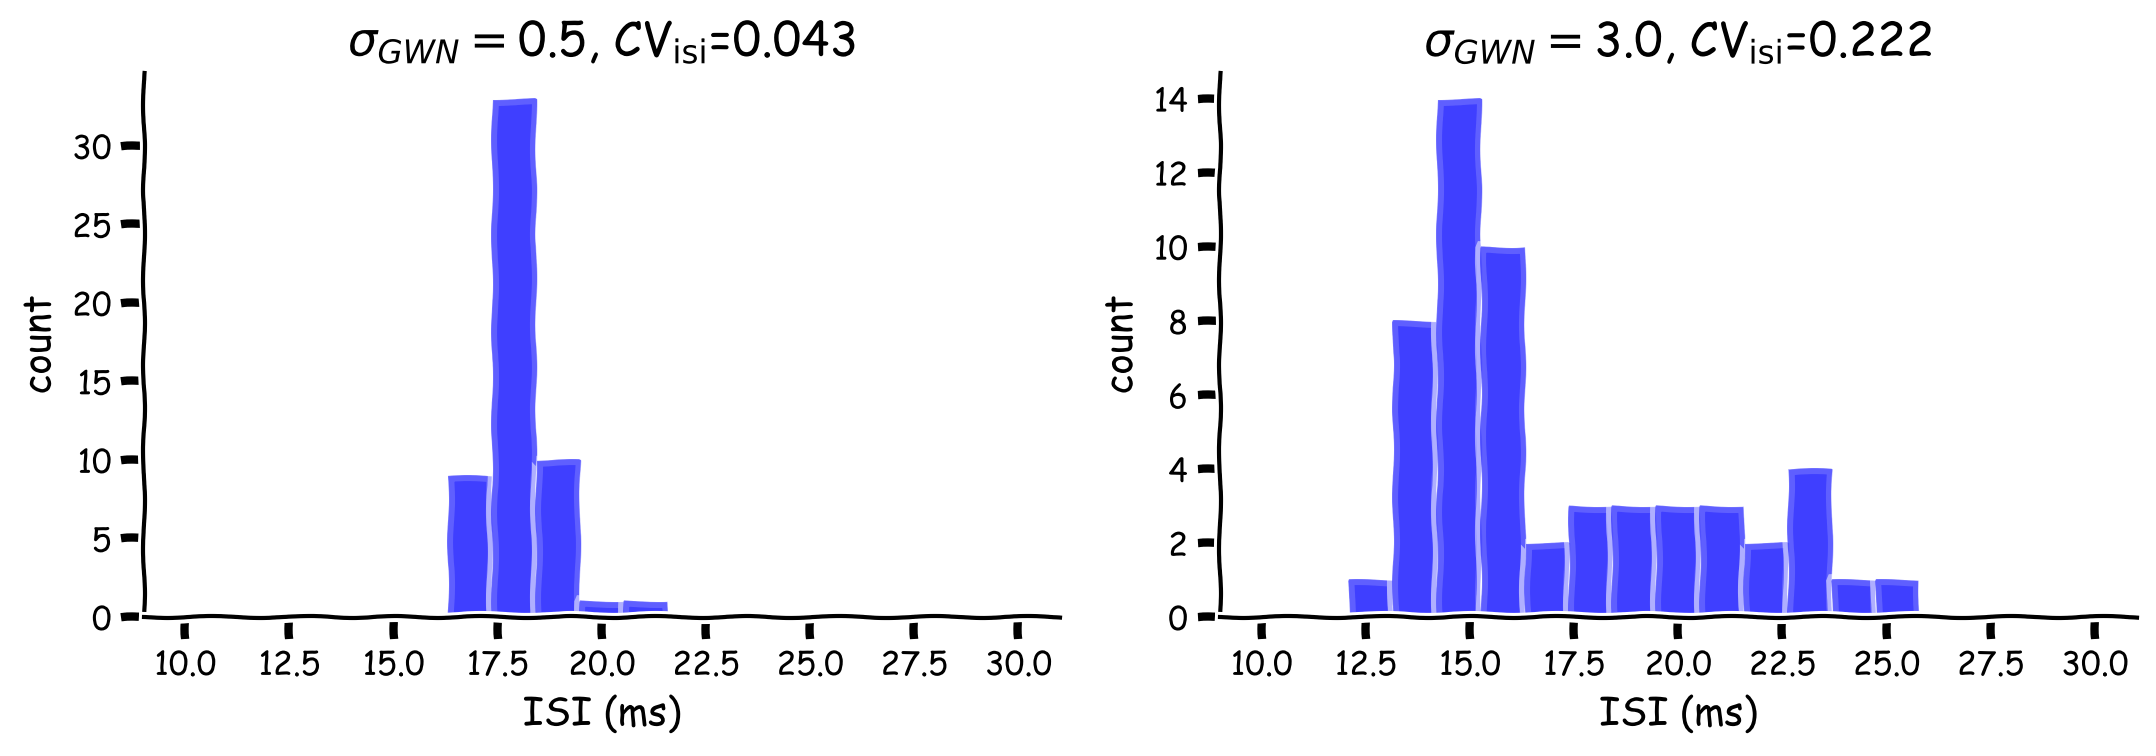

In [11]:
def isi_cv_LIF(spike_times):
    """
    Calculates the inter-spike intervals (isi) and
    the coefficient of variation (cv) for a given spike_train

    Args:
      spike_times : (n, ) vector with the spike times (ndarray)

    Returns:
      isi         : (n-1,) vector with the inter-spike intervals (ms)
      cv          : coefficient of variation of isi (float)

    """

    if len(spike_times) >= 2:
        # Compute isi
        isi = np.diff(spike_times)
        # Compute cv
        cv = isi.std()/isi.mean()
    else:
        isi = np.nan
        cv = np.nan

    return isi, cv


# Set parameters
pars = default_pars(T=1000.)
mu_gwn = 250
sig_gwn1 = 0.5
sig_gwn2 = 3.0

# Run LIF model for sigma = 0.5
I_GWN1 = my_GWN(pars, mu=mu_gwn, sig=sig_gwn1, myseed=2020)
_, sp1 = run_LIF(pars, Iinj=I_GWN1)

# Run LIF model for sigma = 3
I_GWN2 = my_GWN(pars, mu=mu_gwn, sig=sig_gwn2, myseed=2020)
_, sp2 = run_LIF(pars, Iinj=I_GWN2)

# Compute ISIs/CV
isi1, cv1 = isi_cv_LIF(sp1)
isi2, cv2 = isi_cv_LIF(sp2)

# Visualize
my_hists(isi1, isi2, cv1, cv2, sig_gwn1, sig_gwn2)

In [12]:
my_layout.width = '450px'
@widgets.interact(
    sig_gwn=widgets.FloatSlider(0.0, min=0., max=10.,
                                step=0.5, layout=my_layout)
)


def diff_std_affect_fI(sig_gwn):
    pars = default_pars(T=1000.)
    I_mean = np.arange(100., 400., 20)
    spk_count = np.zeros(len(I_mean))
    cv_isi = np.empty(len(I_mean))

    for idx in range(len(I_mean)):
        I_GWN = my_GWN(pars, mu=I_mean[idx], sig=sig_gwn)
        v, rec_spikes = run_LIF(pars, Iinj=I_GWN)
        spk_count[idx] = len(rec_spikes)
        if len(rec_spikes) > 3:
            isi = np.diff(rec_spikes)
            cv_isi[idx] = np.std(isi) / np.mean(isi)

    # Plot the F-I curve i.e. Output firing rate as a function of input mean.
    plt.figure()
    plt.plot(I_mean[spk_count > 5], cv_isi[spk_count > 5], 'bo', alpha=0.5)
    plt.xlabel('Average injected current (pA)')
    plt.ylabel(r'Spike irregularity ($\mathrm{CV}_\mathrm{ISI}$)')
    plt.ylim(-0.1, 1.5)
    plt.grid(True)
    plt.show()

interactive(children=(FloatSlider(value=0.0, description='sig_gwn', layout=Layout(width='450px'), max=10.0, st…